In [1]:
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from pprint import pprint
import itertools

import cp
import base

## Generate random data

In [2]:
np.random.seed(0)
sizes = [10, 20, 30]
rank = 3
tensor, factors, norms, noise = cp.create_data(sizes, rank, noise_factor=0)
complete_tensor = tensor.copy() # Keep a compy of the complete data
W = np.round(np.random.random(tensor.shape)).astype(np.int)
tensor[W==0] = 0

## Find decomposition with cp_wopt

In [3]:
cp_factors, result, _, log = cp.cp_wopt(tensor, W=W, method='cg', rank=rank, init='random', gtol=1e-15)

print(result.message)
print(f'F(x): {result.fun}')
print(f'Number of iterations: {result.nit}')
print(f'Number of function evaluations: {result.nfev}')

Optimization terminated successfully.
F(x): 3.948455681064226e-30
Number of iterations: 66
Number of function evaluations: 110


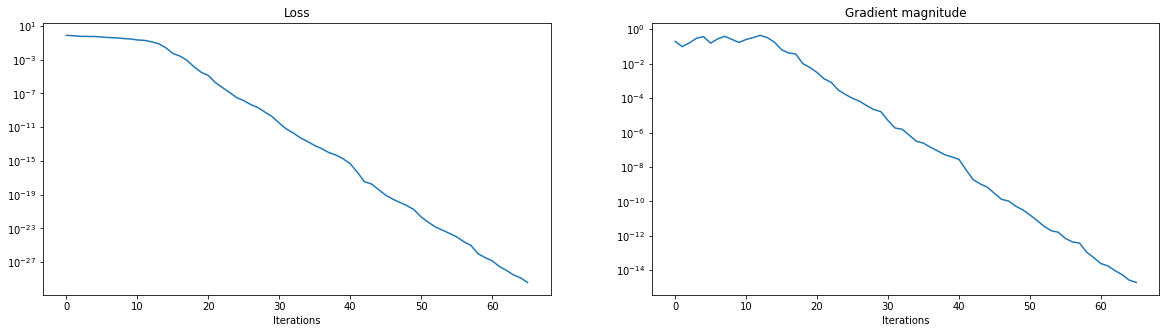

In [4]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(log.loss_values)
ax1.set_title('Loss')
ax1.set_xlabel('Iterations')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(log.gradient_values)
ax2.set_title('Gradient magnitude')
ax2.set_xlabel('Iterations')

ax1.set_yscale('log')
ax2.set_yscale('log')

plt.show()

## Check how well we recover the true factors

In [5]:
score, best_permutation = cp.factor_match_score(factors, cp_factors, weight_penalty=True, fms_reduction='mean')

print(f'Factor match score: {score}')
print(f'Best match permutation: {best_permutation}')

Factor match score: 0.9999999999999932
Best match permutation: (1, 2, 0)


Factor match score: 0.9999999999999941
Best match permutation: (0, 1, 2)


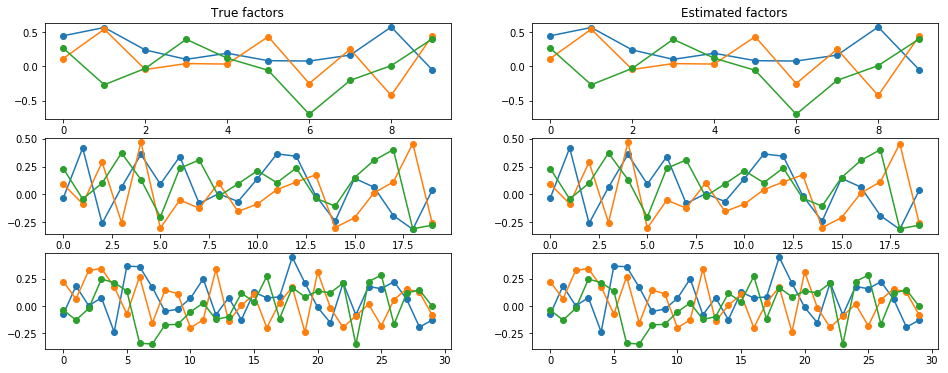

In [6]:
f1, s1, n1 = cp.prepare_for_comparison(factors)
f2, s2, n2 = cp.prepare_for_comparison(cp.permute_factors(best_permutation, cp_factors))
score, best_permutation = cp.factor_match_score(f1, f2, weight_penalty=False, fms_reduction='mean')

print(f'Factor match score: {score}')
print(f'Best match permutation: {best_permutation}')
fig, axes = plt.subplots(len(sizes), 2, figsize=(16, 6))
for i in range(len(factors)):
    axes[i][0].plot(f1[i], '-o')
    axes[0][0].set_title('True factors')
    
    axes[i][1].plot(f2[i], '-o')
    axes[0][1].set_title('Estimated factors')

plt.show()

## Tensor completion score

In [7]:
estimated_tensor = base.ktensor(*tuple(cp_factors))
tcs = cp.tensor_completion_score(complete_tensor, estimated_tensor, W)
print(f"Tensor completion score: {tcs:g}")

Tensor completion score: 3.44852e-15


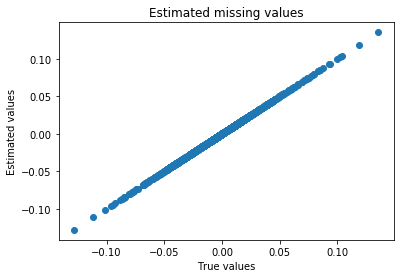

In [8]:
plt.plot(complete_tensor[W==0], estimated_tensor[W==0], 'o')
plt.xlabel("True values")
plt.ylabel("Estimated values")
plt.title("Estimated missing values")
plt.show()